# Imports

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from pygam import LinearGAM, s
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Data Loading

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/WenjiuWang/Beijing-Real-Estate-Price-Forecasting/master/dataset_original.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
url                    318851 non-null object
id                     318851 non-null object
Lng                    318851 non-null float64
Lat                    318851 non-null float64
Cid                    318851 non-null float64
tradeTime              318851 non-null int64
DOM                    160874 non-null float64
followers              318851 non-null int64
totalPrice             318851 non-null float64
price                  318851 non-null int64
square                 318851 non-null float64
bedRoom                318851 non-null object
livingRoom             318851 non-null object
kitchen                318851 non-null int64
bathRoom               318851 non-null int64
floor                  318819 non-null float64
buildingType           318851 non-null int64
constructionTime       318851 non-null int64
renovationCondition    318851 non-null int64
buildingStructur

In [14]:
data.describe()


,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,kitchen,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
count,318851.000000,318851.000000,3.188510e+05,3.188510e+05,160874.000000,318851.000000,318851.000000,318851.000000,318851.000000,318851.000000,...,318851.000000,318851.000000,318851.000000,318851.000000,3.188510e+05,318819.000000,318819.000000,318819.000000,318851.000000,318388.000000
mean,116.418459,39.949591,1.128066e+12,1.429304e+09,28.822339,16.731508,349.030201,43530.436379,83.240597,0.994599,...,3.016130,1999.424029,2.606330,4.451026,6.316486e+01,0.577055,0.645601,0.601112,6.763564,63682.446305
std,0.112054,0.091983,2.356416e+12,5.167998e+07,50.237343,34.209185,230.780778,21709.024204,37.234661,0.109609,...,1.268145,15.381449,1.311739,1.901753,2.506851e+04,0.494028,0.478331,0.489670,2.812616,22329.215447
min,116.072514,39.627030,1.110000e+12,1.022890e+09,1.000000,0.000000,0.100000,1.000000,6.900000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,10847.000000
25%,116.344985,39.893200,1.110000e+12,1.385770e+09,1.000000,0.000000,205.000000,28050.000000,57.900000,1.000000,...,1.000000,1994.000000,1.000000,2.000000,2.500000e-01,0.000000,0.000000,0.000000,6.000000,46339.000000
50%,116.416780,39.934527,1.110000e+12,1.442016e+09,6.000000,5.000000,294.000000,38737.000000,74.260000,1.000000,...,4.000000,2002.000000,3.000000,6.000000,3.330000e-01,1.000000,1.000000,1.000000,7.000000,59015.000000
75%,116.477581,40.003018,1.110000e+12,1.469923e+09,37.000000,18.000000,425.500000,53819.500000,98.710000,1.000000,...,4.000000,2005.000000,4.000000,6.000000,5.000000e-01,1.000000,1.000000,1.000000,8.000000,75950.000000
max,116.732378,40.252758,1.110000e+15,1.517098e+09,1677.000000,1143.000000,18130.000000,156250.000000,1745.500000,4.000000,...,4.000000,2016.000000,4.000000,6.000000,1.000940e+07,1.000000,1.000000,1.000000,13.000000,183109.000000


# Data Cleaning

## Seperate data and labels

In [6]:
labels = data.pop('price')

## Feature classification

In [7]:
num_features = ['Lng' ,'Lat', 'tradeTime', 'square', 'floor', 'kitchen', 'bathRoom', 'livingRoom', 'bedRoom', 'ladderRatio','constructionTime', 'renovationCondition']
cat_features = ['buildingType', 'buildingStructure', 'district', 'Cid', 'elevator', 'fiveYearsProperty', 'subway']
object_features = ['bedRoom', 'livingRoom']

## Numerical Data Transformer

In [8]:
class objToNum(BaseEstimator, TransformerMixin):
  def __init__(self):
      return None
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    for att in object_features:
        X[att] = pd.to_numeric(X[att],errors='coerce')
    return X

num_transformer = Pipeline([
    ('obj', objToNum()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())])

## Categorical Data Transformer

In [9]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

class oneHot(BaseEstimator, TransformerMixin):
  def __init__(self):
      return None
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    ref = ['buildingType', 'buildingStructure', 'district', 'Cid']
    X = pd.DataFrame(data=X, columns=cat_features)
    c = X.columns
    for att in c:
      if att in ref:
        X[att] = X[att].astype(str)
        X = encode_and_bind(X, att)
        X = X.drop(att, axis=1)
    return X
    
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oneHot', oneHot())])

## Full pipeline

In [10]:
full_pipeline = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)                        
])

data = full_pipeline.fit_transform(data)
data = pd.DataFrame(data=data, columns=['Lng', 'Lat', 'tradeTime', 'square', 'bedRoom', 'livingRoom', 'kitchen', 'bathRoom', 'floor', 'constructionTime', 'renovationCondition', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'buildingType_1', 'buildingType_2', 'buildingType_3', 'buildingType_4', 'buildingStructure_0', 'buildingStructure_1', 'buildingStructure_2', 'buildingStructure_3', 'buildingStructure_4', 'buildingStructure_5', 'buildingStructure_6', 'district_1', 'district_10', 'district_11', 'district_12', 'district_13', 'district_2', 'district_3', 'district_4', 'district_5', 'district_6', 'district_7', 'district_8', 'district_9', 'Cid_1110000000000.0', 'Cid_1110000000000000.0', 'Cid_117000000000000.0', 'Cid_118000000000000.0'])

# Data visualizing

In [ ]:
pltdata = data
pltdata['price'] = labels

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


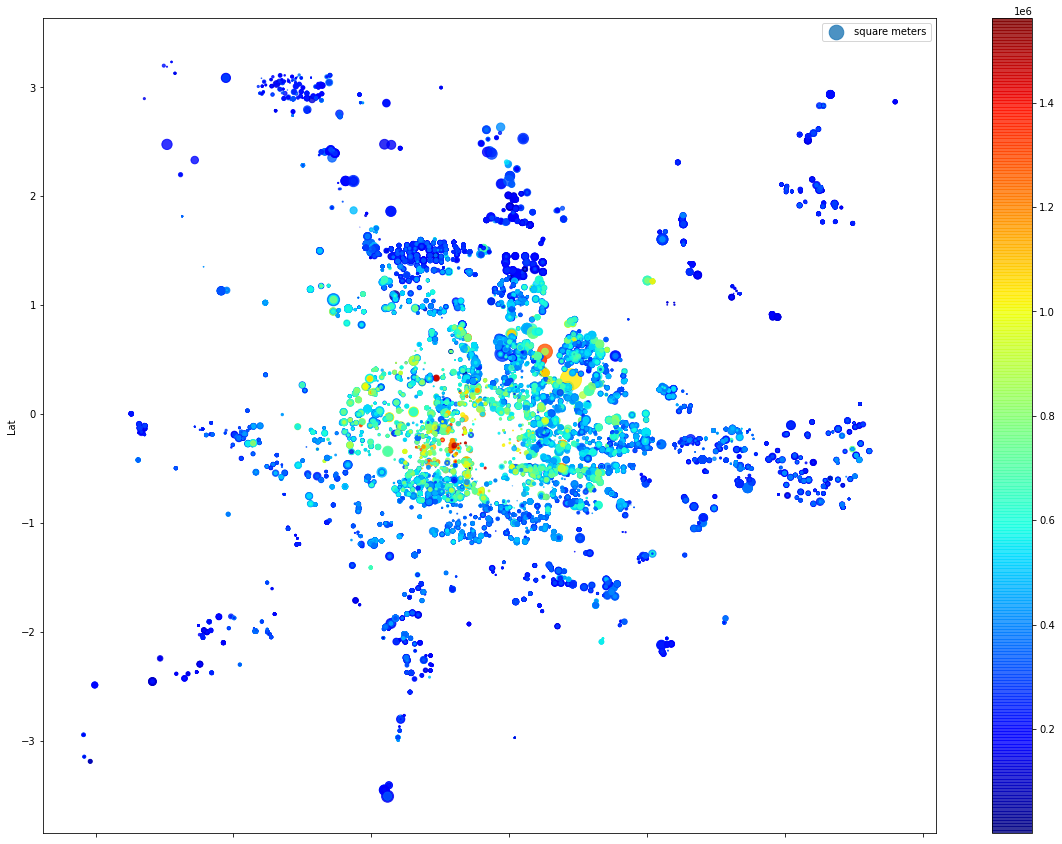

In [ ]:
pltdata.plot(kind="scatter", x="Lng", y="Lat", alpha=0.8,
s=pltdata["square"]*10, label="square meters", figsize=(20,15),
c=pltdata["price"]*10, cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [ ]:
corr_matrix = pltdata.corr()
corr_matrix["price"].sort_values(ascending=False).to_csv("\file.csv")


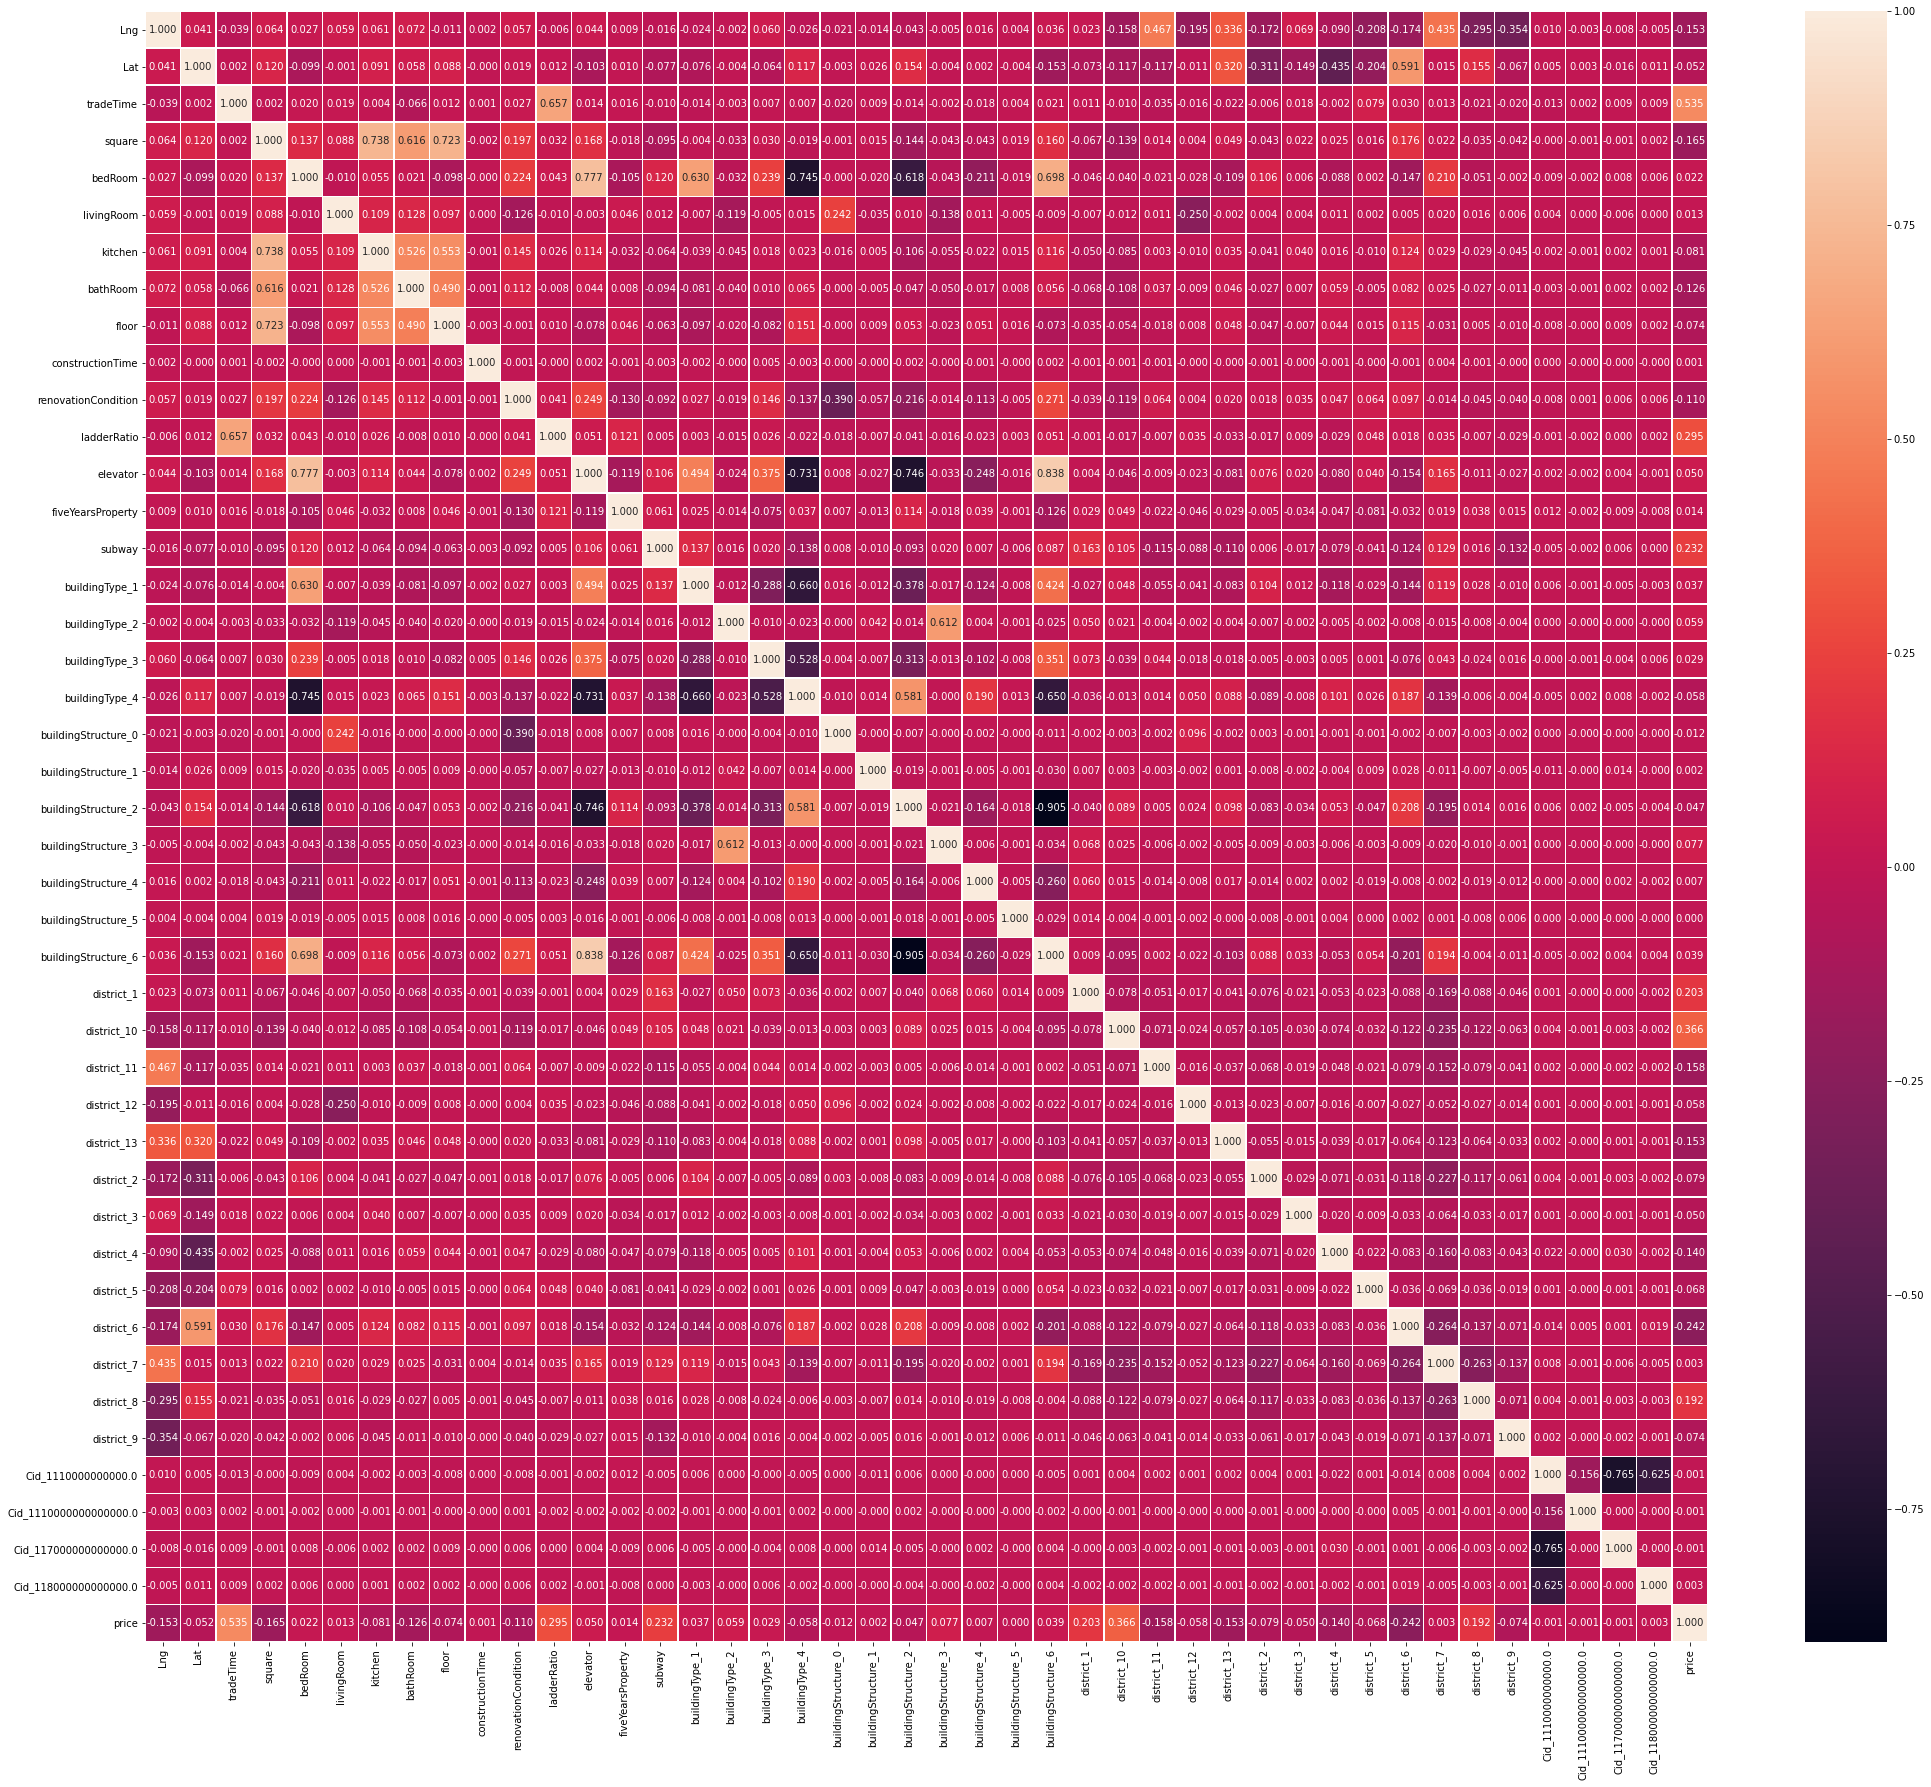

In [ ]:
f,ax = plt.subplots(figsize=(35, 30))
sns.heatmap(pltdata.corr(), annot = True, linewidth = .5, fmt = ".3f",ax = ax)
plt.show()

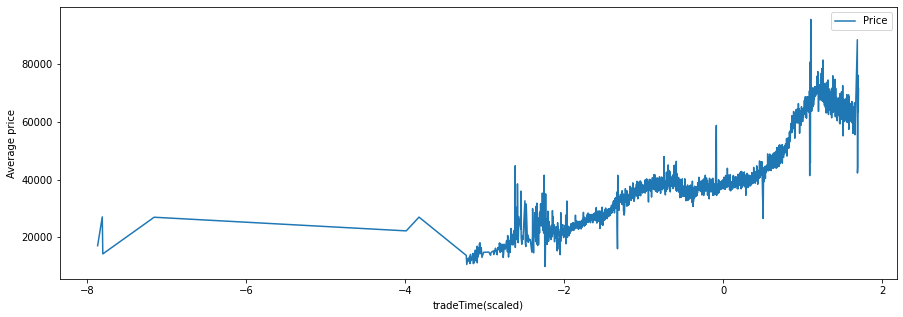

In [ ]:
timePrice=pltdata.groupby('tradeTime').price.mean()
plt.figure(figsize=(15,5))
plt.plot(timePrice, label='Price')
plt.xlabel('tradeTime(scaled)')
plt.ylabel('Average price')
plt.legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a579aa908>,
      dtype=object)

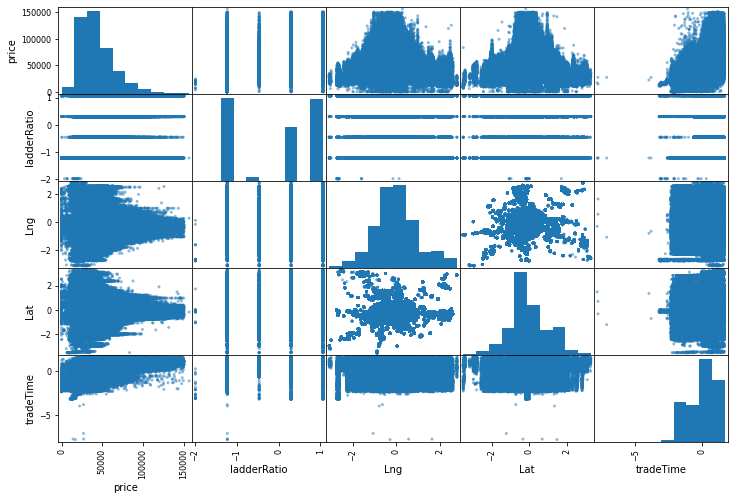

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["price", "ladderRatio","Lng", "Lat", "tradeTime"]
scatter_matrix(data[attributes], figsize=(12, 8))

# Train and Test sets

In [11]:
train_dataset, test_dataset, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=2)

# Model Evaluations

## Neural Network

In [12]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model = keras.models.Sequential([
tf.keras.layers.Dense(43, activation="selu", input_shape=train_dataset.shape[1:], 
kernel_initializer=tf.keras.initializers.LecunNormal()),
tf.keras.layers.Dense(43, activation="selu", input_shape=train_dataset.shape[1:], 
kernel_initializer=tf.keras.initializers.LecunNormal()),
tf.keras.layers.Dense(43, activation="selu", input_shape=train_dataset.shape[1:], 
kernel_initializer=tf.keras.initializers.LecunNormal()),
keras.layers.Dense(1)
])

model.compile(loss=root, optimizer=opt)

history = model.fit(train_dataset, train_labels, epochs=500, validation_split=0.2)

=======] - 12s 2ms/step - loss: 3793.6863 - val_loss: 3947.6443
Epoch 323/500
6377/6377 [==============================] - 12s 2ms/step - loss: 3792.3960 - val_loss: 3961.3203
Epoch 324/500
6377/6377 [==============================] - 12s 2ms/step - loss: 3792.9331 - val_loss: 3935.7595
Epoch 325/500
6377/6377 [==============================] - 12s 2ms/step - loss: 3792.1926 - val_loss: 3965.1147
Epoch 326/500
6377/6377 [==============================] - 12s 2ms/step - loss: 3792.4077 - val_loss: 3949.5120
Epoch 327/500
6377/6377 [==============================] - 12s 2ms/step - loss: 3791.4990 - val_loss: 3951.3313
Epoch 328/500
6377/6377 [==============================] - 12s 2ms/step - loss: 3789.2488 - val_loss: 3940.6548
Epoch 329/500
6377/6377 [==============================] - 13s 2ms/step - loss: 3791.3794 - val_loss: 3944.9744
Epoch 330/500
6377/6377 [==============================] - 11s 2ms/step - loss: 3785.0146 - val_loss: 3958.7854
Epoch 331/500
6377/6377 [===============

## Random Forest

In [ ]:
# R code
"""
## library used 
library(ranger)
library(spm)

### RandomForest
library(ranger)

train = train_dataset
train$price = train_labels$price
xtest = test_dataset
ytest = test_labels
colnames(xtrain)<-list('Lng', 'Lat', 'tradeTime', 'square', 'bedRoom', 'livingRoom', 'kitchen', 'bathRoom', 'floor', 
          'constructionTime', 'renovationCondition', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 
          'buildingType_1', 'buildingType_2', 'buildingType_3', 'buildingType_4', 'buildingStructure_0', 
          'buildingStructure_1', 'buildingStructure_2', 'buildingStructure_3', 'buildingStructure_4', 'buildingStructure_5', 
          'buildingStructure_6', 'district_1', 'district_10', 'district_11', 'district_12', 'district_13', 'district_2', 
          'district_3', 'district_4', 'district_5', 'district_6', 'district_7', 'district_8', 'district_9', 
          'Cid_1110000000000.0', 'Cid_1110000000000000.0', 'Cid_117000000000000.0', 'Cid_118000000000000.0')


colnames(xtest)<-list('Lng', 'Lat', 'tradeTime', 'square', 'bedRoom', 'livingRoom', 'kitchen', 'bathRoom', 'floor', 
          'constructionTime', 'renovationCondition', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 
          'buildingType_1', 'buildingType_2', 'buildingType_3', 'buildingType_4', 'buildingStructure_0', 
          'buildingStructure_1', 'buildingStructure_2', 'buildingStructure_3', 'buildingStructure_4', 'buildingStructure_5', 
          'buildingStructure_6', 'district_1', 'district_10', 'district_11', 'district_12', 'district_13', 'district_2', 
          'district_3', 'district_4', 'district_5', 'district_6', 'district_7', 'district_8', 'district_9', 
          'Cid_1110000000000.0', 'Cid_1110000000000000.0', 'Cid_117000000000000.0', 'Cid_118000000000000.0')



rf <- ranger(price~.,data = train,num.trees = 1000,mtry = 40 ,importance =  'impurity')
pred <- predict(rf,xtest)
sqrt(mean((pred$predictions -ytest$price)^2)) # RMSE = 5067


### Importance plot
plot(rf$variable.importance,ylab = 'Importance')
"""

## Generalized Additive Model 

In [ ]:
# R code
'''
### gam

gam <- gam(price ~ s(Lng,bs="ts")+s(Lat,bs="ts")+s(tradeTime,bs="ts")+s(square,bs="ts")
           +s(constructionTime,bs="ts")+ladderRatio+fiveYearsProperty+subway+buildingType_1+buildingType_2+buildingType_3+buildingType_4+buildingStructure_0
           +buildingStructure_1+buildingStructure_2+buildingStructure_3+buildingStructure_4+buildingStructure_5
           + buildingStructure_6+district_1+ district_10+district_11+district_12+district_13+district_2+district_3 
           +district_4 +district_5+district_6 +district_7+district_8+district_9 +Cid_1110000000000.0+Cid_1110000000000000.0
           +Cid_117000000000000.0+Cid_118000000000000.0+renovationCondition+bedRoom+livingRoom+kitchen+elevator+floor+bathRoom
           +te(Lng,Lat,bs="ts")+s(Lat,Lng,bs="ts")+te(Lng,tradeTime,bs="ts")+te(Lat,tradeTime,bs="ts")+te(Lng,Lat,tradeTime,bs="ts")
           +ladderRatio*fiveYearsProperty
           ,data=xtrain,select = TRUE)

gam$aic

pred <- predict(gam, newdata=xtest)
sqrt(mean((pred-ytest$price)^2)) # RMSE = 9037



###plots
#### 2.1
vis.gam(gam,type = "response", view = c("Lng","Lat"),
        plot.type='persp', phi=60, theta=90)
vis.gam(gam,type = "response", view = c("Lng","Lat"),
        plot.type='persp', phi=30, theta=0)

#### 2.2

vis.gam(gam,type = "response", view = c("Lng","tradeTime"),
        plot.type='persp', phi=60, theta=90)
vis.gam(gam,type = "response", view = c("Lng","tradeTime"),
        plot.type='persp', phi=30, theta=0)

#### 2.3

vis.gam(gam,type = "response", view = c("Lat","tradeTime"),
        plot.type='persp', phi=60, theta=90)
vis.gam(gam,type = "response", view = c("Lat","tradeTime"),
        plot.type='persp', phi=30, theta=0)

# 2.4
vis.gam(gam,type = "response", view = c("Lng","square"),
        plot.type='persp', phi=60, theta=90)
vis.gam(gam,type = "response", view = c("Lng","square"),
        plot.type='persp', phi=30, theta=0)


#### 2.5
vis.gam(gam,type = "response", view = c("Lng","square"),
        plot.type='persp', phi=60, theta=90)
vis.gam(gam,type = "response", view = c("Lng","square"),
        plot.type='persp', phi=30, theta=0)


